Lukas Kreussel

Andreas Ziegler

# Benötigte Module

See requirements.txt

# Kapitel 1: Datenverarbeitung
###  1.1 Konzeptionierung
Zur modellierung könne alle Daten verwendet werden, welche vor Start des Matches zur Verfügung stehen. 

-Dazu zählen Metadaten der Spieler wie Größe/Alter/Herkunft usw.

-Historische Tennis Daten wie Match-Historie, Spieler-Historie, etc.

-Turnierdaten wie Seed und Entry-Art. 

Die zu bauenden Modelle erhalten diese Daten der beiden Spieler und treffen eine Binäre Aussage.
Dabei soll 0 bedeuten dass der erste Spieler gewinnen wird und 1 das der Zweite Spieler gewinnen wird.

###  1.2 Download der Daten

http://www.tennis-data.co.uk/alldata.php

Lädt alle Daten als xls und xlsx Dateien herunter wandelt diese in csv Dateien um und speichert diese im data Ordner.

In [1]:
from modules.datasources import DataSource
dataSource =  DataSource(r"./data")
dataSource.get_tennis_data_uk_data(start_year=2000,end_year=2021)

  warn(msg)


https://github.com/JeffSackmann/tennis_atp

Lädt alle den Regex Patterns entsprechenden csv Dateien aus dem Github Repository herunter und speichert diese im data Ordner.

In [2]:
from github.GithubException import RateLimitExceededException
try:
    #Match the atm_matches_XXXX.csv files 
    dataSource.get_github_data(r"^atp_matches_\d{4}.csv","matches") 
    #Rankings of all Players
    dataSource.get_github_data(r"^(atp_rankings_\d{2}s.csv|atp_rankings_current.csv)","ranking")
    #Player Stats
    dataSource.get_github_data(r"^atp_players.csv","players")
except RateLimitExceededException as e:
    pass

### 1.2 Laden der Daten

Laden der Rohdaten in Pandas Dataframes

In [3]:
import os
from pathlib import Path
import pandas as pd

def load_into_dataframe(directory):
    #Get all *.csv Files in the Directory
    files = [os.path.join(os.getcwd(),file) for file in Path(directory).rglob('*.csv')]
    
    dataframes = []
    for file in files:
        dataframes.append(pd.read_csv(file))
    
    #Concatenate all Dataframes    
    return pd.concat(dataframes)

#Delete 2022 Australian Opens Data if it exists, because we use it for evaluation later
if os.path.isfile(r"./data/JeffSackmann/matches/atp_matches_2022.csv"):
    aus_open = pd.read_csv(r"./data/JeffSackmann/matches/atp_matches_2022.csv")
    data_2022 = aus_open[aus_open["tourney_name"] != "Australian Open"]
    data_2022.to_csv(r"./data/JeffSackmann/matches/atp_matches_2022.csv",index=False)
    
    
rankings = load_into_dataframe(r"./data/JeffSackmann/ranking")
matches = load_into_dataframe(r"./data/JeffSackmann/matches")
players = load_into_dataframe(r"./data/JeffSackmann/players")
matches_uk = load_into_dataframe(r"./data/tennis_data_uk")
matches.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,1968-2029,Dublin,Grass,32,A,19680708,270,202866,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1968-2029,Dublin,Grass,32,A,19680708,271,126914,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1968-2029,Dublin,Grass,32,A,19680708,272,209523,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1968-2029,Dublin,Grass,32,A,19680708,273,100084,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1968-2029,Dublin,Grass,32,A,19680708,274,100132,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1.3 Daten Cleanup und Vereinheitlichung

Some Dataframes have excess colums from the import we remove them here

In [4]:
rankings = rankings.drop(["20200106","1","104745","9985"], axis=1 , errors='ignore')
players = players.drop(["wikidata_id"], axis=1 , errors='ignore')

Different Date-Time formats are confusing -> normalize them to Python Datetime Format

In [5]:
def format_date(df:pd.DataFrame,column:str,format:str,dropNAT:bool=True,sort:bool=True):
    df[column] = pd.to_datetime(df[column],format=format,errors='coerce')
    if dropNAT:
        df = df[df[column].notnull()]
    if sort:
        df = df.sort_values(by=[column])
    return df
    
matches_uk = format_date(matches_uk,"Date","%Y-%m-%d")
rankings = format_date(rankings,"ranking_date","%Y%m%d")
matches = format_date(matches,"tourney_date","%Y%m%d")
players = format_date(players,"dob","%Y%m%d")

Some Dataframes have NAN or NAT values we replace them here

In [6]:
#If no Points are given, set them to 0
rankings["points"] = rankings["points"].fillna(0).astype(int)
#If a Players height is unknown we use the mean height of the Players
players["height"] = players["height"].fillna(int(players["height"].mean())).astype(int)

We have odds from many different sources we combine them here

In [7]:
matches_uk["odds_winner"] = matches_uk[["B365W","B&WW","CBW","EXW","LBW","GBW","IWW","PSW","SBW","SJW","UBW"]].mean(axis=1)
matches_uk["odds_loser"] = matches_uk[["B365L","B&WL","CBL","EXL","LBL","GBL","IWL","PSL","SBL","SJL","UBL"]].mean(axis=1)
matches_uk = matches_uk.drop(["B365W","B&WW","CBW","EXW","LBW","GBW","IWW","PSW","SBW","SJW","UBW"], axis=1 , errors='ignore')
matches_uk = matches_uk.drop(["B365L","B&WL","CBL","EXL","LBL","GBL","IWL","PSL","SBL","SJL","UBL"], axis=1 , errors='ignore')

C:\Users\andyz\AppData\Local\Temp\ipykernel_3340\1624345245.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  matches_uk["odds_winner"] = matches_uk[["B365W","B&WW","CBW","EXW","LBW","GBW","IWW","PSW","SBW","SJW","UBW"]].mean(axis=1)


change score display to the same format

In [8]:
def parseScore(row):
    out = int(0)
    
    if(row["W1"] != 0):
        out = f"{row['W1']}-{row['L1']}"
        if(row["W2"] != 0):
            out += f" {row['W2']}-{row['L2']}"
            if(row["W3"] != 0):
                out += f" {row['W3']}-{row['L3']}"
                if(row["W4"] != 0):
                    out += f" {row['W3']}-{row['L3']}"
                    if(row["W5"] != 0):
                        out += f" {row['W3']}-{row['L3']}"
    
    return out

matches_uk["W1"] = matches_uk["W1"].replace(r'^\s*$', int(0), regex=True).fillna(0).astype(int)
matches_uk["L1"] = matches_uk["L1"].replace(r'^\s*$', int(0), regex=True).fillna(0).astype(int)
matches_uk["W2"] = matches_uk["W2"].replace(r'^\s*$', int(0), regex=True).fillna(0).astype(int)
matches_uk["L2"] = matches_uk["L2"].replace(r'^\s*$', int(0), regex=True).fillna(0).astype(int)
matches_uk["W3"] = matches_uk["W3"].replace(r'^\s*$', int(0), regex=True).fillna(0).astype(int)
matches_uk["L3"] = matches_uk["L3"].replace(r'^\s*$', int(0), regex=True).fillna(0).astype(int)
matches_uk["W4"] = matches_uk["W4"].replace(r'^\s*$', int(0), regex=True).fillna(0).astype(int)
matches_uk["L4"] = matches_uk["L4"].replace(r'^\s*$', int(0), regex=True).fillna(0).astype(int)
matches_uk["W5"] = matches_uk["W5"].replace(r'^\s*$', int(0), regex=True).fillna(0).astype(int)
matches_uk["L5"] = matches_uk["L5"].replace(r'^\s*$', int(0), regex=True).fillna(0).astype(int)


matches_uk["score"] = matches_uk.apply(lambda row: parseScore(row), axis=1)
matches_uk = matches_uk.drop(["W1","W2","W3","W4","W5","Wsets"], axis=1 , errors='ignore')
matches_uk = matches_uk.drop(["L1","L2","L3","L4","L5","Lsets"], axis=1 , errors='ignore')

We only care about completed matches

In [9]:
matches_uk = matches_uk[matches_uk["Comment"] == "Completed"]

matches_uk = matches_uk.drop(["Comment"], axis=1 , errors='ignore')

### 1.4 Data Encoding and Transformation

Some Data is hard to understand for a Model -> we need to Transform the Data to a format the Model can understand.

Example: when we give a Model the Rank of the 2 Players it will never compare the rank directly -> it cant compare the Skill-Gap between the 2 Players. -> We need a Funktion that transforms the Rankings of 2 Players to a relative Skill-Gap.

We need to do something similar to the Players Age/Height. 


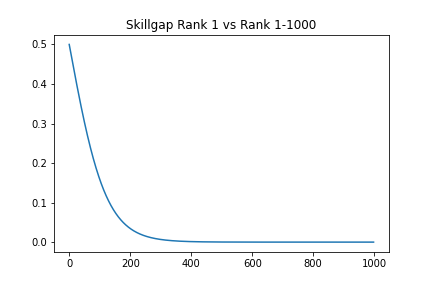
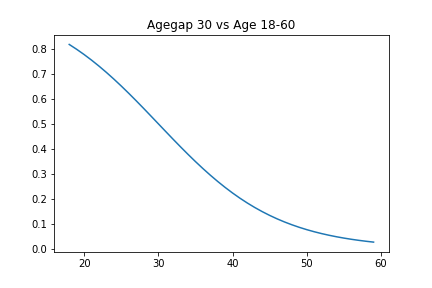
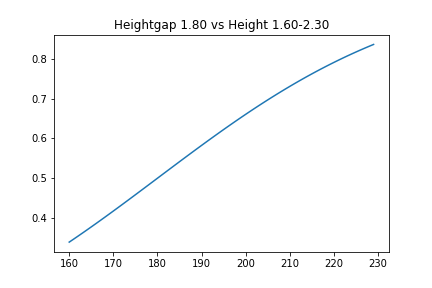
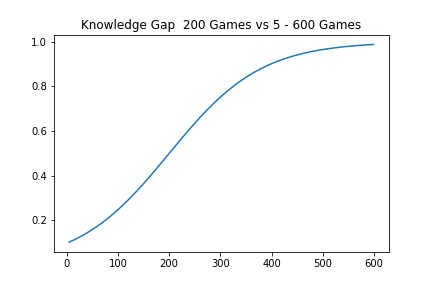
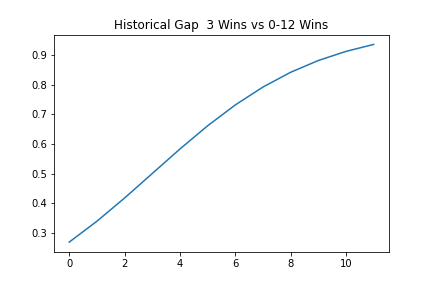
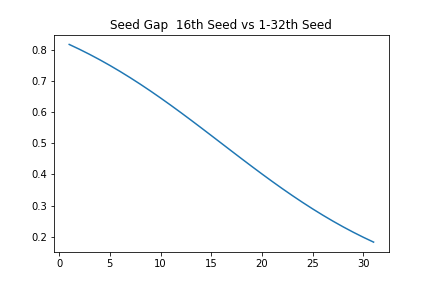

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from modules.gaps import *
from modules.FlowLayout import FlowLayout

Plot = FlowLayout()

fig, ax = plt.subplots(1, 1)
ax.plot([skill_gap(1,rank) for rank in range(1,1000)])
ax.set_title('Skillgap Rank 1 vs Rank 1-1000')
fig.patch.set_facecolor('xkcd:white')
Plot.add_plot(ax)
plt.close()

fig, ax = plt.subplots(1, 1)
ax.plot(range(18,60),[age_gap(30,age) for age in range(18,60)])
ax.set_title('Agegap 30 vs Age 18-60')
fig.patch.set_facecolor('xkcd:white')
Plot.add_plot(ax)
plt.close()

fig, ax = plt.subplots(1, 1)
ax.plot(range(160,230),[height_gap(180,age) for age in range(160,230)])
ax.set_title('Heightgap 1.80 vs Height 1.60-2.30')
fig.patch.set_facecolor('xkcd:white')
Plot.add_plot(ax)
plt.close()

fig, ax = plt.subplots(1, 1)
ax.plot(range(5,600),[knowledge_gap(200,games) for games in range(5,600)])
ax.set_title('Knowledge Gap  200 Games vs 5 - 600 Games')
fig.patch.set_facecolor('xkcd:white')
Plot.add_plot(ax)
plt.close()

fig, ax = plt.subplots(1, 1)
ax.plot(range(0,12),[historical_gap(3,games) for games in range(0,12)])
ax.set_title('Historical Gap  3 Wins vs 0-12 Wins')
fig.patch.set_facecolor('xkcd:white')
Plot.add_plot(ax)
plt.close()

fig, ax = plt.subplots(1, 1)
ax.plot(range(1,32),[seed_gap(16,seeds) for seeds in range(1,32)])
ax.set_title('Seed Gap  16th Seed vs 1-32th Seed')
fig.patch.set_facecolor('xkcd:white')
Plot.add_plot(ax)
plt.close()

Plot.PassHtmlToCell()

The Final Score of a Game is difficult Datapoint if we want to Predict it with a Model we need a way to transform the Final Score to a relative Score.

Idea: 
    We want to transform the Score into a Float Value.

    Example:
        if we play a Set of 3 and the First Player wins 2-0 we want to transform the Score to 0
        if we play a Set of 3 and the Second Player wins 0-2 we want to transform the Score to 1

        if the Game ends 2-1 we want to transform the Score to 0.33
        if the Game ends 1-2 we want to transform the Score to 0.66

    Implementation:
        Check which Player won the Game and set the Score to 1 or 0.
        Add/Subtract 1/SetCount to/from the Score for each Set the other Player won.


In [11]:
from modules.scoreparser import ScoreParser

scoreParser = ScoreParser()
print(scoreParser.parse_string("7-5 4-6 6-2"))

(2, 1)


### 1.5 Player Data Cleanup and Aggregation
It's impossible for a Model to understand a Playername -> we need to Transform the Playername to Fields the Model can understand.

We want to provide a Function that takes a Players Last- and Firstname and returns matching Player-Metadata and their Ranking.

To Make this possible we need to create some Lookups for the Players.

To make the Search fast we use dictionarys to keep a constant Lookup-Time.

Building these Lookups takes some Time -> Chache them in JSON files.

In [12]:
from tqdm import tqdm
from modules.lookups import PlayerRankLookUp,PlayerMetadataLookUp,PlayerMatchHistoryLookUp

LOOKUP_DIRECTORY = r"./lookups"
Path(LOOKUP_DIRECTORY).mkdir(parents=True, exist_ok=True)

#Player Ranking Data over Time
player_rank_lookup = PlayerRankLookUp(LOOKUP_DIRECTORY)
player_rank_lookup.load(rankings)
#Player Name to ID and Metadata
player_metadata_lookup = PlayerMetadataLookUp(LOOKUP_DIRECTORY)
player_metadata_lookup.load(players)
#Player Name to Match History
player_match_history_lookup = PlayerMatchHistoryLookUp(LOOKUP_DIRECTORY,player_metadata_lookup)
player_match_history_lookup.load(matches)
print("All Lookups loaded")

Building Player Ranking Lookup ...: 100%|██████████| 15226/15226 [03:19<00:00, 76.42it/s] 


Loaded PlayerRankLookUp from player_rank_lookup.json


Building Player Meatdata Lookup ...: 44433it [00:05, 8023.22it/s] 


Loaded PlayerMetadataLookUp from player_metadata_lookup.json


Building Player MatchHistory Lookup ...: 180467it [00:20, 8893.62it/s] 


Skipped 8446 Matches because one of the Players was not present in the PlayerMetadataLookup!
Loaded PlayerMatchHistoryLookUp from player_matchHistory_lookup.json
All Lookups loaded


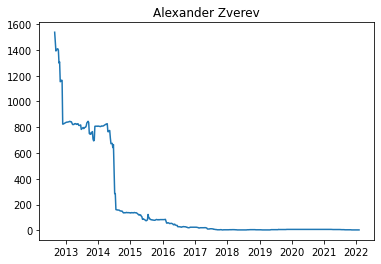

In [13]:
#Testing the Lookups by finding 'Alexander Zverev' and 'Radu Albot'(random tennisplayer name) and plotting his ranking History

player_metadate = player_metadata_lookup['Alexander Zverev']
player_ranking = player_rank_lookup[str(player_metadate["id"])]
plt.plot([item["date"] for item in player_ranking],[item["rank"] for item in player_ranking])
plt.title('Alexander Zverev')
plt.show()

In [14]:
# Testing the match history Lookup by finding 'Alexander Zverev' and 'Novak Djokovic' match history
import datetime

print(player_match_history_lookup.getMatchHistory('Alexander Zverev', 'Novak Djokovic',datetime.date(2020,1,1)))

len(player_match_history_lookup.getAllMatches('Alexander Zverev',datetime.date(2019,1,1)))

[{'won': True, 'date': datetime.date(2017, 5, 15), 'score': '6-4 6-3', 'best_of': 3}, {'won': False, 'date': datetime.date(2018, 10, 8), 'score': '6-2 6-1', 'best_of': 3}, {'won': False, 'date': datetime.date(2018, 11, 12), 'score': '6-4 6-1', 'best_of': 3}, {'won': True, 'date': datetime.date(2018, 11, 12), 'score': '6-4 6-3', 'best_of': 3}, {'won': False, 'date': datetime.date(2019, 5, 27), 'score': '7-5 6-2 6-2', 'best_of': 5}]


264

Tennis Data UK has different Playernames so we unify them

In [15]:
from modules.nameconverter import nameconverter
from tqdm import tqdm
tqdm.pandas()

nc = nameconverter(player_metadata_lookup)

matches_uk_extended = matches_uk.progress_apply(nc.complete_name,axis=1)
matches_uk_extended = matches_uk_extended[(matches_uk_extended.T != 0).any()]
matches_uk_extended = matches_uk_extended.dropna(subset=["odds_winner", "odds_loser"])

print(f'could noch convert {len(nc.notfound)} names.')

matches_uk_extended.head()

100%|██████████| 56534/56534 [00:10<00:00, 5178.20it/s]


could noch convert 136 names.


,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,LRank,WPts,LPts,MaxW,MaxL,AvgW,AvgL,odds_winner,odds_loser,score
68,3,Doha,Qatar Open,2001-01-01 00:00:00,International,Outdoor,Hard,1st Round,3,YEVGENY KAFELNIKOV,...,49,NaN,NaN,NaN,NaN,NaN,NaN,1.300000,2.766667,6-2 6-2
67,3,Doha,Qatar Open,2001-01-01 00:00:00,International,Outdoor,Hard,1st Round,3,FREDRIK JONSSON,...,65,NaN,NaN,NaN,NaN,NaN,NaN,2.033333,1.556667,7-5 6-3
64,3,Doha,Qatar Open,2001-01-01 00:00:00,International,Outdoor,Hard,1st Round,3,ALEX CALATRAVA,...,54,NaN,NaN,NaN,NaN,NaN,NaN,1.850000,1.690000,7-5 4-6 6-4
62,3,Doha,Qatar Open,2001-01-01 00:00:00,International,Outdoor,Hard,1st Round,3,HASSAN ARAZI,...,51,NaN,NaN,NaN,NaN,NaN,NaN,1.326667,2.666667,7-6 6-4
61,2,Chennai,TATA Open,2001-01-01 00:00:00,International,Outdoor,Hard,The Final,3,MICHAL TABARA,...,122,NaN,NaN,NaN,NaN,NaN,NaN,1.862500,1.735000,6-2 7-6


### 1.6 Building the Training Data

Now we have all the Data we need to build the Training Data.

In [16]:
#First we drop all Columns we don't need
arbitrary_data = ["tourney_id","match_num","minutes","winner_id","loser_id"] #Data thats not usefull to us
match_specific = ["w_bpFaced","w_bpSaved","w_SvGms","w_2ndWon","w_1stWon","w_1stIn","w_svpt","w_df","w_ace","l_bpFaced","l_bpSaved","l_SvGms","l_2ndWon","l_1stWon","l_1stIn","l_svpt","l_df","l_ace"] #Way to specific -> we dont know this before the match
matches = matches.drop(arbitrary_data+match_specific, axis=1 , errors='ignore')

#Now we drop every Row with undefined rank or age or height
for column in ["winner_rank","loser_rank","winner_age","loser_age","winner_ht","loser_ht"]:
    matches = matches[matches[column].notnull()]

matches.head()

,tourney_name,surface,draw_size,tourney_level,tourney_date,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,...,loser_ht,loser_ioc,loser_age,score,best_of,round,winner_rank,winner_rank_points,loser_rank,loser_rank_points
3132,US Open,Grass,128,G,1973-08-29,NaN,NaN,Jaime Fillol,R,180.0,...,173.0,USA,24.112252,6-1 7-6 7-5,5,R128,24.0,NaN,59.0,NaN
3130,US Open,Grass,128,G,1973-08-29,NaN,NaN,Erik Van Dillen,R,183.0,...,173.0,FRA,25.341547,3-6 6-3 6-2 7-6,5,R128,38.0,NaN,56.0,NaN
3129,US Open,Grass,128,G,1973-08-29,4.0,NaN,Rod Laver,L,173.0,...,168.0,USA,20.947296,6-0 6-2 6-2,5,R128,5.0,NaN,63.0,NaN
3128,US Open,Grass,128,G,1973-08-29,NaN,NaN,Patrice Dominguez,L,173.0,...,178.0,GER,24.331280,7-6 6-3 6-0,5,R128,36.0,NaN,20.0,NaN
3127,US Open,Grass,128,G,1973-08-29,NaN,NaN,Vijay Amritraj,R,193.0,...,185.0,USA,35.668720,6-4 7-6 6-2,5,R128,43.0,NaN,126.0,NaN


Now we build our Training Data by creating a Dataframe with the Features and the Target.

We will ignore all Featrues that are not relevant based on the Feature Importance of a previously trained Model.


![image info](./images/featureimportance.png)


Features:

    seedgap,skillgap,agegap,heightgap,knowledgegap,historicalgap,best_of
Target:

    score (relative float 0 to 1)
    
    score_b (binary 0 or 1)

In [17]:
import os
from modules.dataframetransformer import transform_jeffSackmann,transform_tennisData_UK

if not os.path.isfile("traindata.csv"): 
    traindata = transform_jeffSackmann(matches,scoreParser,player_match_history_lookup)
    traindata.to_csv("traindata.csv",index=False)
    
if not os.path.isfile("evaldata.csv"): 
    evaldata = transform_tennisData_UK(matches_uk_extended,scoreParser,player_match_history_lookup,player_metadata_lookup,player_rank_lookup)
    evaldata.to_csv("evaldata.csv",index=False)

Building Train-Dataframe ...:   0%|          | 0/124712 [00:00<?, ?it/s]x:\GitHub\ml-projekt-modularbeit\src\modules\lookups.py:207: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return [match for match in matches if match["date"] <= date]
x:\GitHub\ml-projekt-modularbeit\src\modules\lookups.py:195: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return [match for match in self.data[player][opponent] if match["date"] <= date]
Building Evaluation-Dataframe ...: 100%|██████████| 43394/43394 [00:41<00:00, 1035.85it/s]


Missing Skill Gap: 4250


# 2. Data Analysis


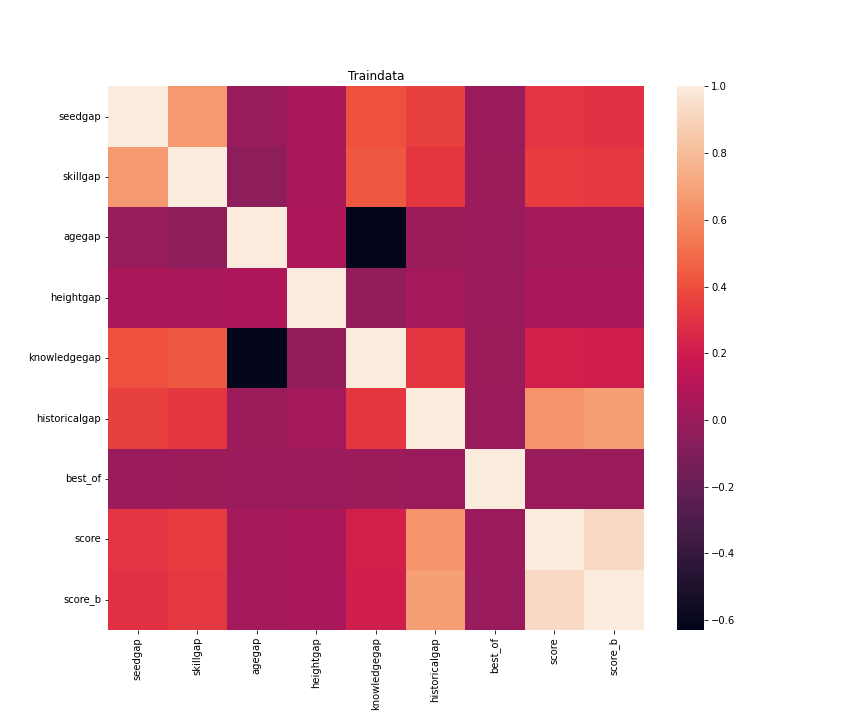
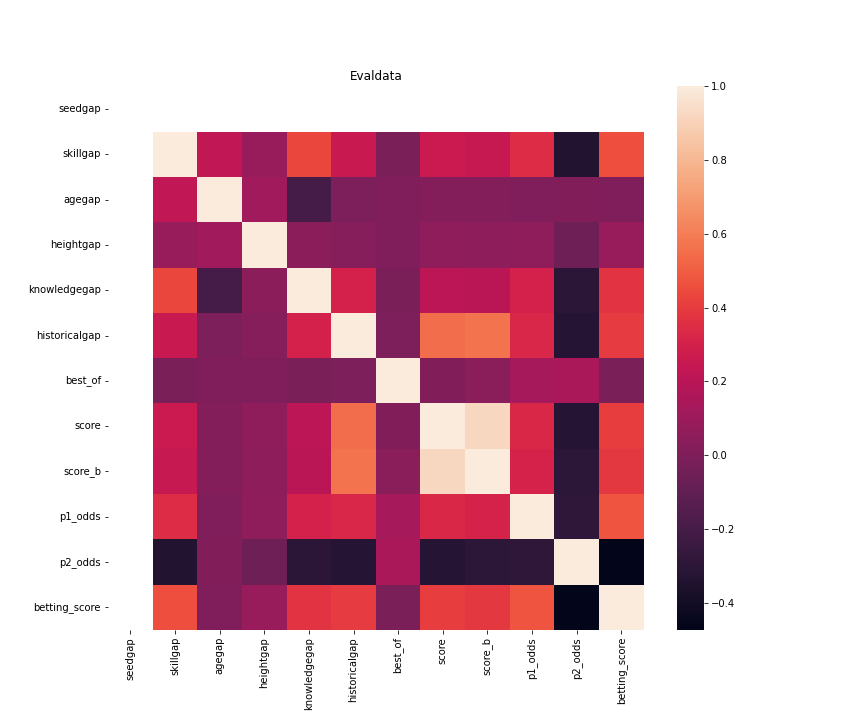

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from modules.FlowLayout import FlowLayout

Plot = FlowLayout()

#load the data
traindata = pd.read_csv("traindata.csv")
evaldata = pd.read_csv("evaldata.csv")
def plot_heatmap(df:pd.DataFrame,title:str):
    corr = df.corr()
    fig, ax = plt.subplots(1, 1,figsize=(12,10))
    sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,ax = ax)
    ax.set_title(title)
    fig.patch.set_facecolor('xkcd:white')
    Plot.add_plot(ax)
    plt.close()
    
plot_heatmap(traindata,"Traindata")
plot_heatmap(evaldata,"Evaldata")

Plot.PassHtmlToCell()

# 3. Model Training

### 3.1 Data Preparation

Our Data still contains some NAN Values and categorical Data -> we want to transform this into numerical Data.

We use the category_encoders package to do this.

In [19]:
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import numpy as np
traindata = pd.read_csv("traindata.csv")
traindata = traindata.drop(["date"],axis=1)

#split x,y data
y = traindata["score"]
y_binary = traindata["score_b"]
x = traindata.drop(["score","score_b","best_of"],axis=1) 

#Build the Prepocessing Pipeline
pipeline = Pipeline(
        [
        #encode categorical data
        #("categorical_encoder",ce.CatBoostEncoder()),
        #Use the full Value Range
        ("scaler",StandardScaler())
        ]
    )

x_transformed = pipeline.fit_transform(x,y_binary)

#Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(x_transformed,y_binary, test_size=0.3)

### 3.2 Training Pipeline 

We use a GridSearchCV to Optimize the Parameters of our Model.


In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score,recall_score,roc_auc_score,precision_score
from joblib import dump, load
from sklearn.base import BaseEstimator
MODEL_DIR = "./models"
os.makedirs(MODEL_DIR,exist_ok=True)

def optimize_model(model,parameters,x_train,y_train,cv=5,n_jobs=12,print_results=False):
    """
    Optimizes a model with the given Parameters on the given data
    """
    gSearch = GridSearchCV(model, parameters,n_jobs=n_jobs ,cv=cv)
    gSearch.fit(x_train, y_train)
    if print_results:
        print(pd.DataFrame(gSearch.cv_results_).sort_values("mean_test_score",ascending=False))
    else:
        print("Best Score:",gSearch.best_score_)
    return gSearch.best_params_


def model_exists(name):
    """
    Check if a Model Exists
    """
    model_path = os.path.join(MODEL_DIR,f"{name}.joblib")
    return os.path.exists(model_path)
    
def save_model(model,name):
    """
    Saves the model to the disk
    """
    model_path = os.path.join(MODEL_DIR,f"{name}.joblib")
    dump(model, model_path)
    
def load_model(name)->BaseEstimator: 
    """
    Loads a Model from Disk
    """
    if model_exists(name):
        model_path = os.path.join(MODEL_DIR,f"{name}.joblib")
        return load(model_path)
    return None

### 3.3 Building the Models

3.3.1 Entscheidungsbaum-Klassifizierer

In [21]:
from sklearn.tree import DecisionTreeClassifier

DECISION_TREE = "decision_tree"

if not model_exists(DECISION_TREE):
    possible_parameters = {
        "criterion": ["gini","entropy"],
        "splitter" : ["best","random"],
        "max_depth": list(range(2,12,1)),
        "min_samples_leaf": list(range(1,10,2))
    }
    best_params_tree = optimize_model(DecisionTreeClassifier(),possible_parameters,X_train,y_train)

    decision_tree = DecisionTreeClassifier(**best_params_tree)
    decision_tree.fit(X_train,y_train)
    save_model(decision_tree,"decision_tree")

Best Score: 0.8898821051125644


3.3.2 Logistisches Regressionsmodell

In [22]:
from sklearn.linear_model import LogisticRegression

LOGISTIC_REGRESSION = "logistic_regression"
if not model_exists(LOGISTIC_REGRESSION):
    possible_parameters = {
        "solver": ["lbfgs","saga","liblinear","newton-cg"],
        "C" : [0.001,0.01,0.1,1,10,100,1000],
        "max_iter": [100,1_000,10_000],
    }
    best_params_linear = optimize_model(LogisticRegression(),possible_parameters,X_train,y_train)
    logisticRegression = LogisticRegression(**best_params_linear)
    logisticRegression.fit(X_train,y_train)
    save_model(logisticRegression,LOGISTIC_REGRESSION)

Best Score: 0.88830999418698


3.3.3 Ensamble Model

In [23]:
from sklearn.ensemble import RandomForestClassifier
ENSAMBLE = "ensamble"

if not model_exists(ENSAMBLE):
    possible_parameters = {
        "n_estimators": [50,100,200],
        "max_depth" : [2,3,4],
        "min_samples_leaf": [best_params_tree["min_samples_leaf"]],
    }
    best_params_ensamble = optimize_model(RandomForestClassifier(),possible_parameters,X_train,y_train)
    randomForest = RandomForestClassifier(**best_params_ensamble)
    randomForest.fit(X_train,y_train)
    save_model(randomForest,ENSAMBLE)

Best Score: 0.8897444035806348


### 3.4 Model Evaluation

Here we evaluate the Models and compare them.
Using their Precision, Recall and ROC-AUC-Score.

We also look at the Feature Importance of the Models.

In [24]:
from sklearn.metrics import accuracy_score,recall_score,roc_auc_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

def score_model(y_true,y_predicted):
    roc_auc = None
    try:
        roc_auc = roc_auc_score(y_true,y_predicted)
    except:
        pass
    
    return {
        "Accuracy":accuracy_score(y_true,y_predicted),
        "Recall":recall_score(y_true,y_predicted,zero_division=1),
        "ROC_AUC": roc_auc
    }
    
def ImpurityBasedImportance(forest,feature_names):
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    forest_importances = pd.Series(importances, index=feature_names)
    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
    plt.show()

def PermutationBasedImportance(forest,feature_names):
    importances = permutation_importance(forest, X_train, y_train, n_repeats=10)
    forest_importances = pd.Series(importances.importances_mean, index=feature_names)
    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=importances.importances_std, ax=ax)
    ax.set_title("Feature importances using Permutation Importance")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
    plt.show()

decision_tree Score:
{'Accuracy': 0.8902216986184, 'Recall': 0.8764702751609984, 'ROC_AUC': 0.8903069086888562}


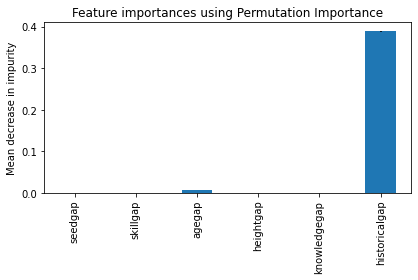

logistic_regression Score:
{'Accuracy': 0.8888293884545357, 'Recall': 0.8889243706423972, 'ROC_AUC': 0.8888287999017255}


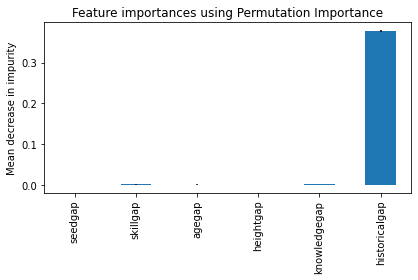

ensamble Score:
{'Accuracy': 0.8890703652136661, 'Recall': 0.8848794507424557, 'ROC_AUC': 0.8890963340247112}


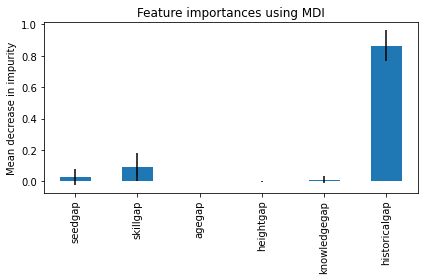

In [25]:
#Load all Models from Disk
model_names = [DECISION_TREE,LOGISTIC_REGRESSION,ENSAMBLE]
models = {}
for model_name in model_names:
    model = load_model(model_name)
    if model:
        models[model_name] = model

#Score Them   
for model_name,model in models.items():
    print(f"{model_name} Score:")
    y_predicted = model.predict(X_test)
    print(score_model(y_test,y_predicted))
    #Permutation Importance
    if model_name == "ensamble":
        ImpurityBasedImportance(model,x.columns)
    else:
        PermutationBasedImportance(model,x.columns)

### Analysis:
All models perform nearly identical and very well.
But they seam to be highly dependent on the Historical-Gap Data.


Therefore the Ensamble Model would be the best model, because it relies less on the Historical-Gap and more on the other Features. => It still can be use when we don't have any Historical Data.



Bonus: MLP to Beat the other Models and maybe beat the Bookmaker

In [26]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout


X_MLP_train, X_MLP_test, y_MLP_train, y_MLP_test = train_test_split(x_transformed,y, test_size=0.3)

# Create the model
input_shape = (X_train.shape[1],)
mlp_model = Sequential()
mlp_model.add(Dense(70, input_shape=input_shape, activation='relu'))
mlp_model.add(Dropout(0.2))
mlp_model.add(Dense(35, activation='relu'))
mlp_model.add(Dropout(0.4))
mlp_model.add(Dense(20, activation='relu'))
mlp_model.add(Dropout(0.6))
mlp_model.add(Dense(1, activation='relu'))

mlp_model.compile(loss='MAE', optimizer='adam', metrics=['accuracy'])
mlp_model.fit(X_MLP_train, y_MLP_train, epochs=25, batch_size=1000, verbose=1, validation_split=0.2)

result = mlp_model.predict(X_MLP_test)
result = result > 0.5

y_MLP_test = y_MLP_test > 0.5

score_model(y_MLP_test,result)

Epoch 1/25
70/70 [==============================] - 1s 6ms/step - loss: 0.3844 - accuracy: 0.3855 - val_loss: 0.2785 - val_accuracy: 0.4588
Epoch 2/25
70/70 [==============================] - 0s 4ms/step - loss: 0.3002 - accuracy: 0.4631 - val_loss: 0.2372 - val_accuracy: 0.5555
Epoch 3/25
70/70 [==============================] - 0s 4ms/step - loss: 0.2669 - accuracy: 0.4972 - val_loss: 0.2185 - val_accuracy: 0.5600
Epoch 4/25
70/70 [==============================] - 0s 4ms/step - loss: 0.2490 - accuracy: 0.5185 - val_loss: 0.2167 - val_accuracy: 0.5607
Epoch 5/25
70/70 [==============================] - 0s 4ms/step - loss: 0.2377 - accuracy: 0.5341 - val_loss: 0.2139 - val_accuracy: 0.5614
Epoch 6/25
70/70 [==============================] - 0s 4ms/step - loss: 0.2302 - accuracy: 0.5435 - val_loss: 0.2123 - val_accuracy: 0.5615
Epoch 7/25
70/70 [==============================] - 0s 4ms/step - loss: 0.2245 - accuracy: 0.5471 - val_loss: 0.2109 - val_accuracy: 0.5608
Epoch 8/25
70/70 [==

{'Accuracy': 0.8871693263360823,
 'Recall': 0.9230401275577996,
 'ROC_AUC': 0.8868964194687503}

# 4. Explaining a Decision Tree Model
Ein Entscheidungsbaum versucht die Daten immer auf Grund von einer Entscheidung in 2 kleinere Datensätze aufzuteilen, die jeweils eher dem einen oder anderen Ergebniss zuzuordnen sind. Mit jedem der beiden kleineren Datensätze wird wieder das gleiche gemacht und dass solange bis das Ergebniss ziemlich genau vorhergesagt werden kann.
Zum Aufteilen der Datensätze wird sich immer genau ein Feature, alse eine Eigenschaft, der Daten angeschaut und ein Schwellwert festgelegt an dem die Daten aufgeteilt werden. An welchen Eigenschaften und bei welchen Werten die Daten getrennt werden wird bei der Erstellung des Entscheidungsbaums festgelegt.
Im nächsten Bild ist der Entscheidungsbaum abgebildet, den wir für unsere Vorhersagen verwenden.

In den Tabellen, die wir online Gefunden haben sind sehr viele Informationen enthalten, die für die Entscheidung nicht verwendet werden können, so dass diese erst bearbeitet werden müssen um verwendet werden zu können. Das heißt, dass alle Daten, die erst nach dem Match vorhanden sind entfernt werden und aus den anderen Daten versucht wird aussagekräftigere Informationen zu erstellt. Zum Beispiel gehen wir alle Matches durch und suchen für jedes Matchup ob und wie sie schon vorher gegeneinander gespielt haben und speichern das mit ab.

Die wichtigesten Daten die wir dabei berechnen sind:

historicalgap => Verlauf bisheriger Matches gegeneinander

skillgap => allgemeiner Rankingunterschied

agegap => Altersunterschied

knowledgegap => Unterschied in der Anzahl der gespielter Tournierspiele

seedgap => Tournierseed unterschied

Die Daten, die wir verwenden, müssen so verändert werden, dass diese auch für das Modell verständlich sind, deswegen sind alle Werte mit Zahlen zwischen -1 und 1 dargestellt. Also wenn Spieler 1 einen Vorteil hat dann sind die Werte näher an -1 und wenn Spieler 2 einen Vorteil hat näher an der 1 bei einem Unentschieden ist der Wert 0.
Als Ergebniss wenn Spieler 1 gewinnt ist die Ausgabe des Models eine 0 und wenn Spieler 2 gewinnt eine 1.

Am Bild des Baumes kann man das Vorgehen erklären:
Im obersten Kasten sind 100% samples also alle Daten noch in einem. Danach wird der Datensatz an der historicalgap gespalten. Dazu wird verglichen, ob der jeweilige Wert jeweils größer oder kleiner als das Kriterium ist an dem getielt wird..
Bei den nachfolgenden Kasten sind Verfärbungen zu erkennen, die je nach Stärke angeben wie sicher das eine oder andere Ergebniss ist. Orange heist in unserem Fall Spieler 1 gewinnt und Blau bedeutet Spieler 2 gewinnt.

Es ist zu Erkennen, dass die historicalgap den stärksten Einfluss hat jedoch nicht komplett alleine Ausschalggebend für das Ergebniss ist.

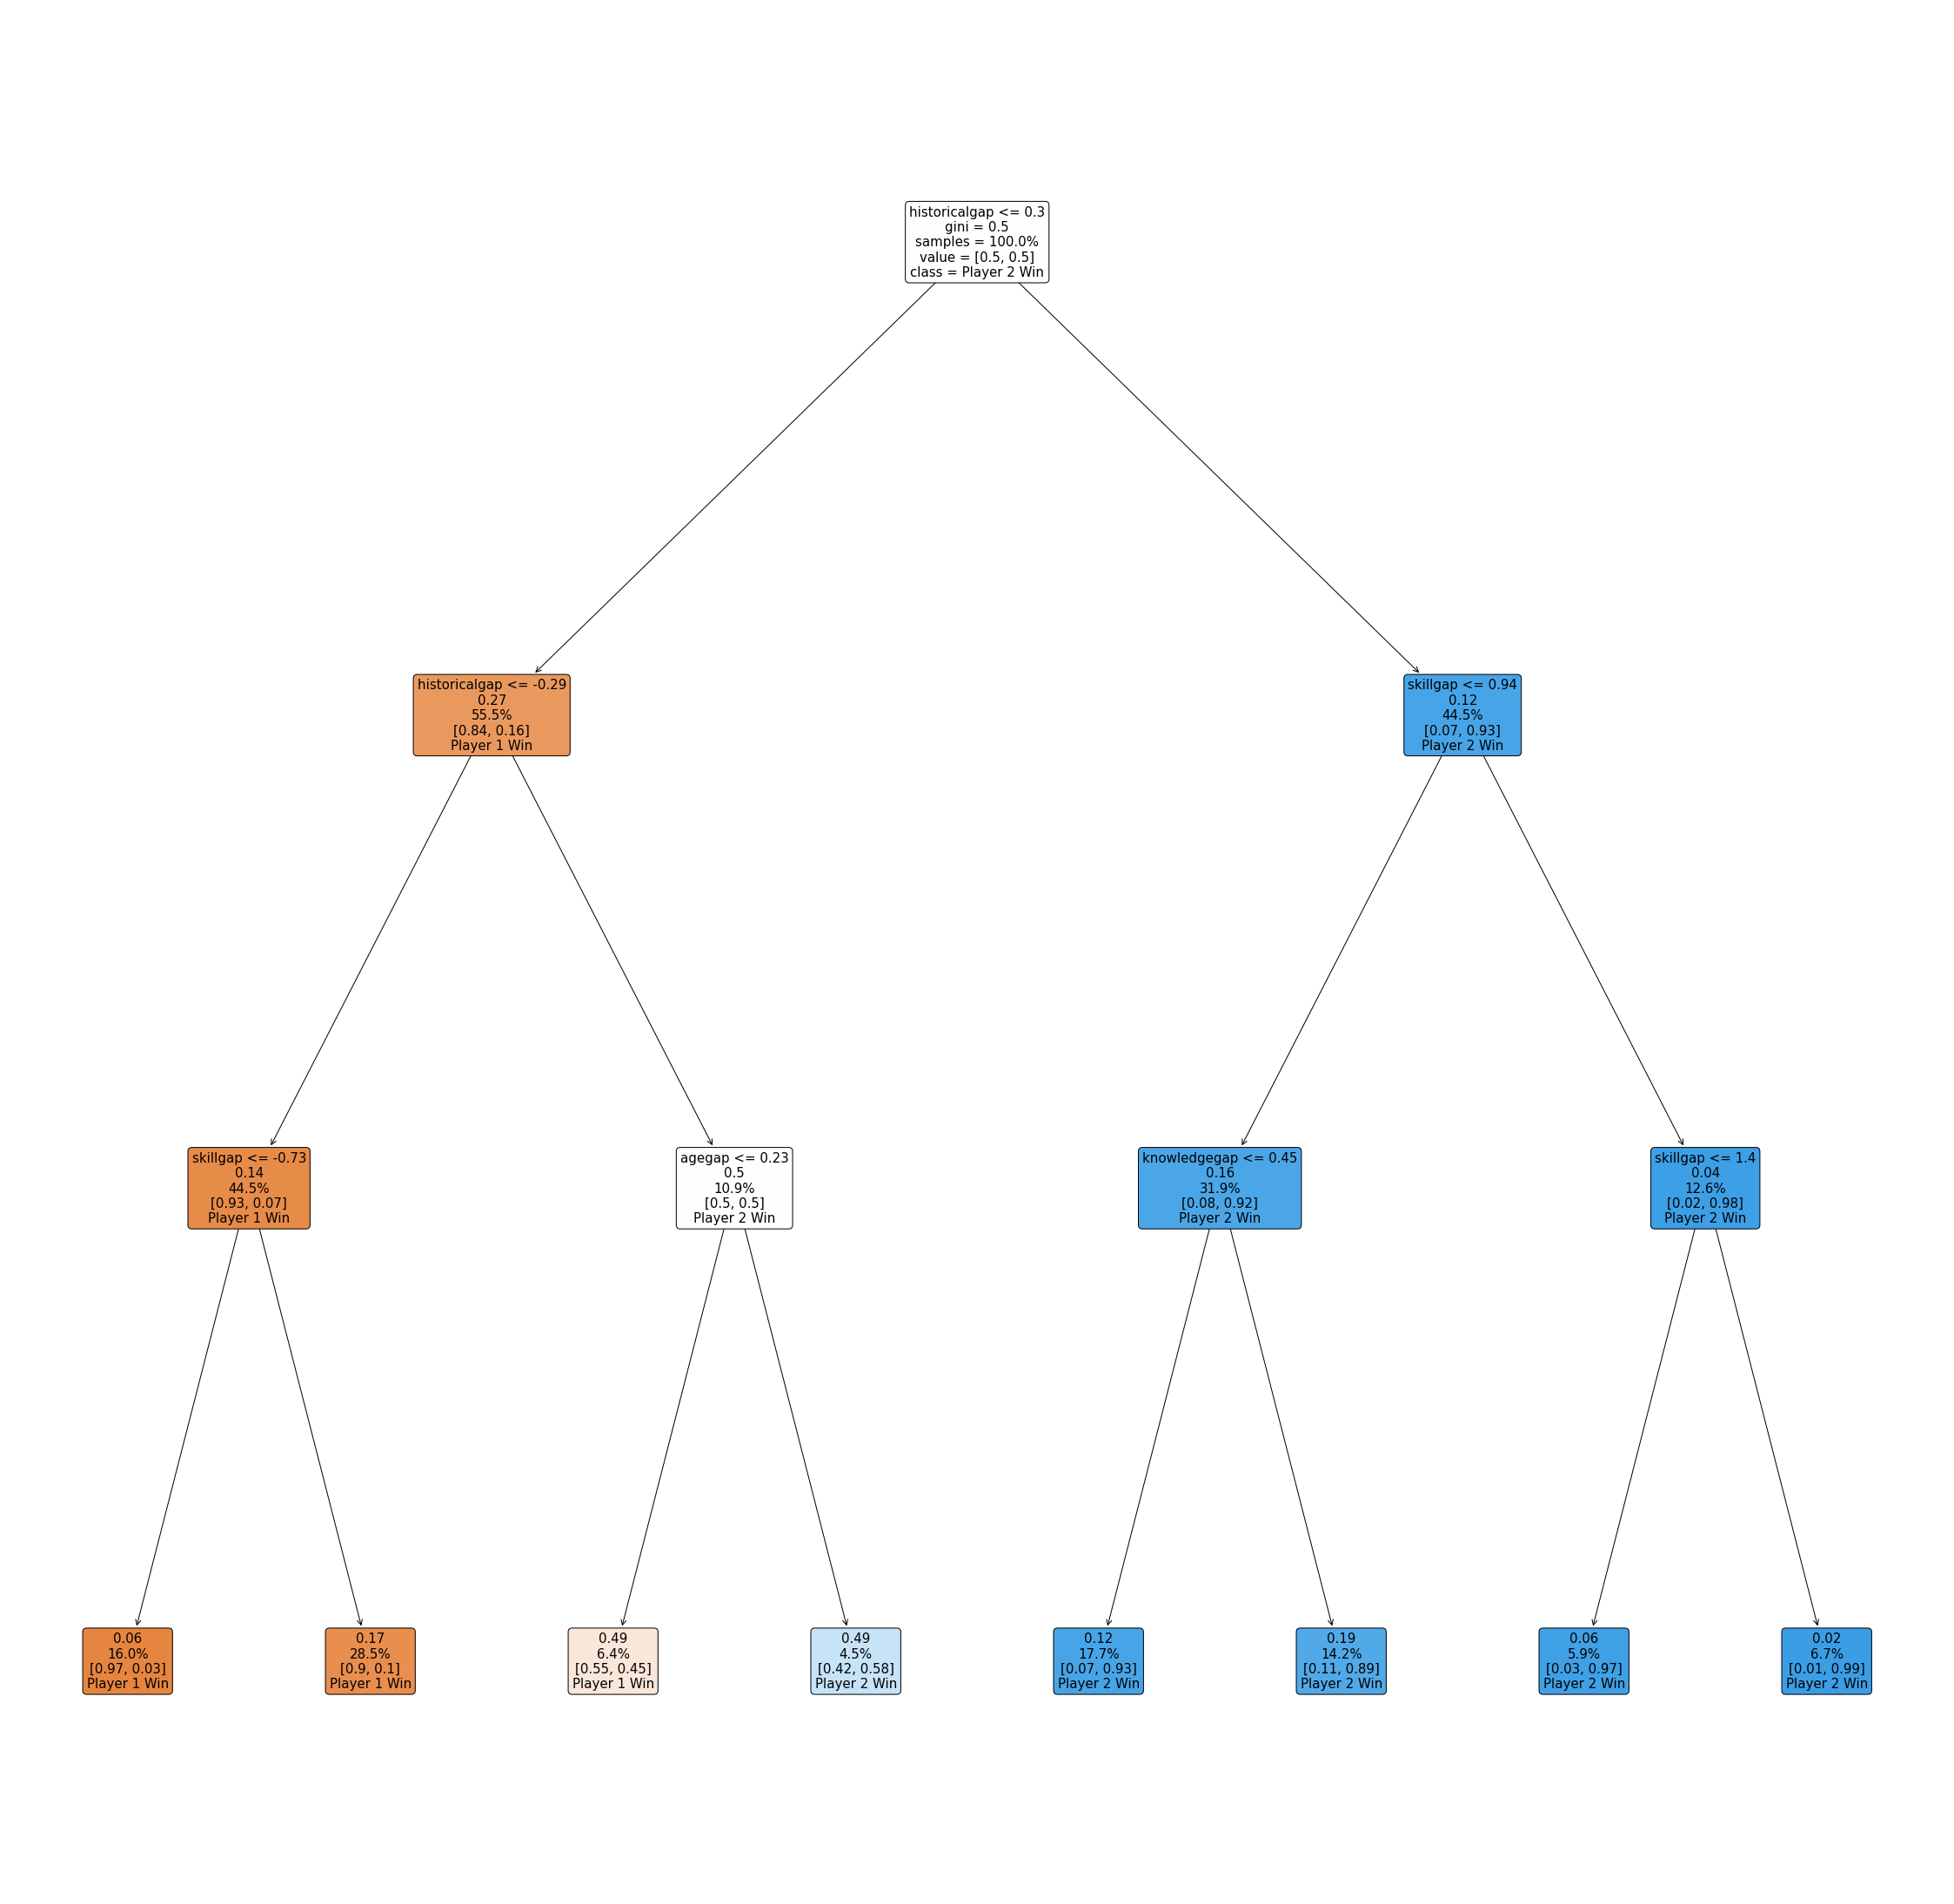

In [27]:
from sklearn.tree import plot_tree
model = load_model("decision_tree")
fig = plt.figure(figsize=(40,40))
text = plot_tree(model,
          feature_names=x.columns,
          class_names=["Player 1 Win","Player 2 Win"],
          filled=True,
          fontsize=15,
          label='root',
          proportion=True,
          precision=2,
          rounded=True,
          max_depth=4
          )

# 5. Validation against the 2022 Australian Open

In [28]:
#Get the Data
from modules.datasources import DataSource
import pandas as pd

dataSource =  DataSource(r"./data")
dataSource.get_github_data(r"atp_matches_2022.csv","2022")

australian_open = pd.read_csv(r"./data/JeffSackmann/2022/atp_matches_2022.csv")
australian_open = australian_open[australian_open["tourney_name"] == "Australian Open"]
australian_open.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
162,2022-580,Australian Open,Hard,128,G,20220117,100,200175,NaN,NaN,...,41.0,25.0,12.0,12.0,7.0,15.0,77,836,146,458
163,2022-580,Australian Open,Hard,128,G,20220117,101,126205,NaN,NaN,...,56.0,33.0,12.0,13.0,5.0,10.0,41,1317,180,362
164,2022-580,Australian Open,Hard,128,G,20220117,102,106214,NaN,NaN,...,42.0,23.0,21.0,13.0,6.0,13.0,96,748,190,348
165,2022-580,Australian Open,Hard,128,G,20220117,103,132283,25,NaN,...,69.0,51.0,13.0,15.0,8.0,12.0,26,1860,110,685
166,2022-580,Australian Open,Hard,128,G,20220117,104,104792,17,NaN,...,43.0,24.0,11.0,11.0,4.0,10.0,20,2373,64,976


In [29]:
#Transform the Data
import os 
if not os.path.isfile("australianopen.csv"):
    australian_open = format_date(australian_open,"tourney_date","%Y%m%d",dropNAT=False,sort=False)
    
    australian_open_transformed = transform_jeffSackmann(australian_open,scoreParser,player_match_history_lookup)
    australian_open_transformed.to_csv("australianopen.csv",index=False)

Building Train-Dataframe ...:   0%|          | 0/127 [00:00<?, ?it/s]x:\GitHub\ml-projekt-modularbeit\src\modules\lookups.py:207: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return [match for match in matches if match["date"] <= date]
x:\GitHub\ml-projekt-modularbeit\src\modules\lookups.py:195: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return [match for match in self.data[player][opponent] if match["date"] <= date]
Building Train-Dataframe ...: 100%|██████████| 127/127 [00:00<00:00, 1494.11it/s]


In [30]:
#Load the Data 
australian_open_transformed = pd.read_csv("australianopen.csv").drop(["date"],axis = 1)
australian_open_transformed["heightgap"] = australian_open_transformed["heightgap"].fillna(0.5).astype(float)
#score on entire dataset
y = australian_open_transformed["score_b"]
australian_open_transformed.drop(["score_b","score","best_of"],axis=1,inplace=True)
x = pipeline.transform(australian_open_transformed)

for model_name,model in models.items():
    if model_name == 'mlp':
        continue
    print(f"{model_name} Score:")
    y_predicted = model.predict(x)
    print(score_model(y,y_predicted))

decision_tree Score:
{'Accuracy': 0.6141732283464567, 'Recall': 0.5441176470588235, 'ROC_AUC': 0.6195164506480557}
logistic_regression Score:
{'Accuracy': 0.7007874015748031, 'Recall': 0.6764705882352942, 'ROC_AUC': 0.7026420737786642}
ensamble Score:
{'Accuracy': 0.5826771653543307, 'Recall': 0.5294117647058824, 'ROC_AUC': 0.5867397806580259}



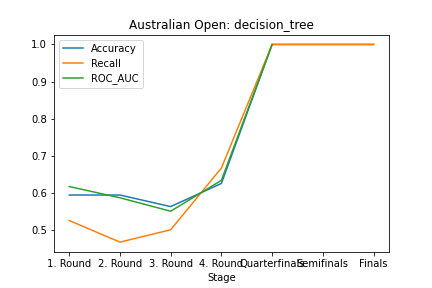
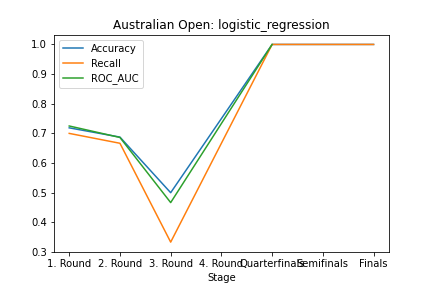
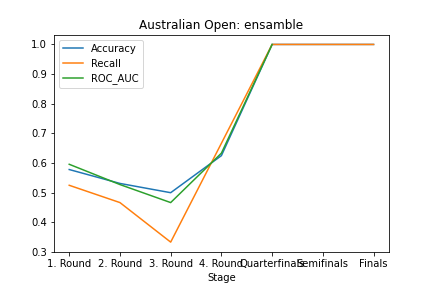

In [31]:
from modules.FlowLayout import FlowLayout

Plot = FlowLayout()
#Now we check the different Stages ot the Turnament and plot the Scores at each stage

rounds = {
    "1. Round" : slice(0,64),
    "2. Round" : slice(64,96),
    "3. Round" : slice(96,112),
    "4. Round" : slice(112,120),
    "Quarterfinals" : slice(120,124),
    "Semifinals" : slice(124,126),
    "Finals": slice(126,127)
}

def build_score_dict():
    return {
        "Accuracy":[],
        "Recall":[],
        "ROC_AUC":[],
    }
scores={}
for model in models.keys():
    scores[model] = build_score_dict()

for name,size in rounds.items(): 
    y_stage = y[size]
    x_stage = x[size]
    for model_name,model in models.items():
        y_predicted = model.predict(x_stage)
        stage_scores = score_model(y_stage,y_predicted)
        for key in stage_scores:
            scores[model_name][key].append(stage_scores[key])

def plot_scores(model_scores,name):
    fig, ax = plt.subplots(1, 1)
    for key in model_scores:
        ax.plot(rounds.keys(),model_scores[key],label=key)
    ax.set_xlabel("Stage")
    ax.legend(model_scores.keys())
    ax.set_title(f"Australian Open: {name}")
    fig.patch.set_facecolor('xkcd:white')
    Plot.add_plot(ax)
    plt.close()
  
for key in scores:
    plot_scores(scores[key],key)

Plot.PassHtmlToCell()

### Analysis:

Normaly we would expect to have better Scores at the start of the turnament because the skillgap between the players is higher => our models should be better at predicting the winner.

But this is not the case here.


If we look at the data we can see that in the first few matches we dont have enought data on lesser known players and we cant calculate the skill/historical/knowledge gap. If we look at our feature importances we can see that these are the most important features for the models. => If we dont supply this data the model predictions will be significally worse.

In the later stages of the Tournament unknown Players will mostly be kicked out by better known / established Players.
We have a lot more data on these players and can calculate the skill/historical/knowledge gap correctly.
Now our models are able to make better predictions and our score gets better.


## 5.1 Certainty of the Model

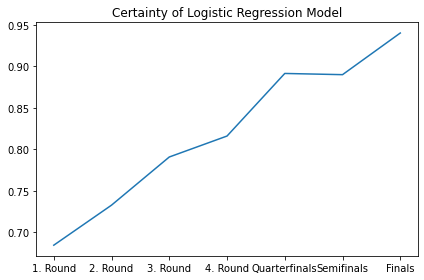

In [32]:
logisticRegression = models[LOGISTIC_REGRESSION]


probs = []
for name,size in rounds.items(): 
    x_stage = x[size]
    round_proba = logisticRegression.predict_proba(x_stage)
    probs.append(np.mean(np.max(round_proba,axis=1)))
    
plt.plot(rounds.keys(),probs)
plt.title("Certainty of Logistic Regression Model")
plt.tight_layout()
plt.show()

The Certainty of the Logistic Regression Model matches the Observations we made in the Scoring-Analysis of the Models.

At the Start of the Tournament we are missing some Data therefore the Model is less certain about the winner. In the Later Stages we have enought Data and the Certainty increases.



# 6. "Beat" the Bookmaker

In [33]:

evaldata = pd.read_csv("evaldata.csv")

evaldata["date"] =  pd.to_datetime(evaldata["date"],format="%Y-%m-%d",errors='coerce')

#split x,y data
y_eval = evaldata["score"]
y_eval_binary = evaldata["score_b"]
y_betting_score = evaldata["betting_score"]
y_p1_odds = evaldata["p1_odds"]
y_p2_odds = evaldata["p2_odds"]
x_eval = evaldata.drop(["score","score_b","best_of","p1_odds","p2_odds","betting_score","date"],axis=1) 
x_eval = pipeline.transform(x_eval)

print("Our Models:")
for model_name,model in models.items():
    print(f"{model_name} Score:")
    y_predicted = model.predict(X_test)
    print(score_model(y_test,y_predicted))

print("Wettanbieter Metrics:")
print(f"Accuracy {accuracy_score(y_eval_binary,y_betting_score)}")
print(f"Recall {recall_score(y_eval_binary,y_betting_score)}")
print(f"ROC_AUC {roc_auc_score(y_eval_binary,y_betting_score)}")

Our Models:
decision_tree Score:
{'Accuracy': 0.8902216986184, 'Recall': 0.8764702751609984, 'ROC_AUC': 0.8903069086888562}
logistic_regression Score:
{'Accuracy': 0.8888293884545357, 'Recall': 0.8889243706423972, 'ROC_AUC': 0.8888287999017255}
ensamble Score:
{'Accuracy': 0.8890703652136661, 'Recall': 0.8848794507424557, 'ROC_AUC': 0.8890963340247112}
Wettanbieter Metrics:
Accuracy 0.6924409339707615
Recall 0.6899665853878805
ROC_AUC 0.6924990115045109


Check a gainst the MLP-Model

In [34]:
result = mlp_model.predict(x_eval)
result = result > 0.5

print("Deep Learning Model Metrics:")
print(f"Accuracy {accuracy_score(y_eval_binary,result)}")
print(f"Recall {recall_score(y_eval_binary,result)}")
print(f"ROC_AUC {roc_auc_score(y_eval_binary,result)}")

Deep Learning Model Metrics:
Accuracy 0.7903877687706413
Recall 0.8579427436105843
ROC_AUC 0.7888021286719304


Betting strategy

In [35]:
evaldata['decision_tree'] = models['decision_tree'].predict(x_eval)
evaldata['logistic_regression'] = models['logistic_regression'].predict(x_eval)
evaldata['ensamble'] = models['ensamble'].predict(x_eval)
evaldata['mlp'] = mlp_model.predict(x_eval)
evaldata.head()

,date,seedgap,skillgap,agegap,heightgap,knowledgegap,historicalgap,best_of,score,score_b,p1_odds,p2_odds,betting_score,decision_tree,logistic_regression,ensamble,mlp
0,2001-01-01,0.5,0.324464,0.320821,0.441930,0.336757,0.208609,3,0.000000,0,1.300000,2.766667,0,0,0,0,0.000000
1,2001-01-01,0.5,0.091123,0.651355,0.541570,0.194313,0.582570,3,1.000000,1,1.556667,2.033333,0,1,1,1,0.957615
2,2001-01-01,0.5,0.491667,0.407333,0.622459,0.339244,0.582570,3,0.666667,1,1.690000,1.850000,0,1,1,1,0.957615
3,2001-01-01,0.5,0.500000,0.679179,0.541570,0.863473,0.500000,3,0.000000,0,1.326667,2.666667,0,1,0,0,0.839511
4,2001-01-01,0.5,0.606669,0.562177,0.475021,0.500000,0.582570,3,1.000000,1,1.735000,1.862500,0,1,1,1,0.957615


In [36]:
import random

input_per_game = 100

def bet(row):
    winner_odds = row['p1_odds'] if not row['score_b'] else row['p2_odds']
    expected_return = input_per_game * winner_odds
    for modelname in models.keys():
        row[modelname] = expected_return if row[modelname] == row['score_b'] else -input_per_game
    row["mlp"] = expected_return if  (row["mlp"] > 0.5) == row['score_b'] else -input_per_game
    row['perfect'] = expected_return
    row['random'] = expected_return if random.randint(0,1) else -input_per_game
    return row

bet_results = evaldata.progress_apply(bet,axis=1)
bet_results.head()

100%|██████████| 43299/43299 [01:00<00:00, 720.85it/s]


,date,seedgap,skillgap,agegap,heightgap,knowledgegap,historicalgap,best_of,score,score_b,p1_odds,p2_odds,betting_score,decision_tree,logistic_regression,ensamble,mlp,perfect,random
0,2001-01-01,0.5,0.324464,0.320821,0.441930,0.336757,0.208609,3,0.000000,0,1.300000,2.766667,0,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000
1,2001-01-01,0.5,0.091123,0.651355,0.541570,0.194313,0.582570,3,1.000000,1,1.556667,2.033333,0,203.333333,203.333333,203.333333,203.333333,203.333333,-100.000000
2,2001-01-01,0.5,0.491667,0.407333,0.622459,0.339244,0.582570,3,0.666667,1,1.690000,1.850000,0,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
3,2001-01-01,0.5,0.500000,0.679179,0.541570,0.863473,0.500000,3,0.000000,0,1.326667,2.666667,0,-100.000000,132.666667,132.666667,-100.000000,132.666667,132.666667
4,2001-01-01,0.5,0.606669,0.562177,0.475021,0.500000,0.582570,3,1.000000,1,1.735000,1.862500,0,186.250000,186.250000,186.250000,186.250000,186.250000,-100.000000


In [37]:
print(f"If you bet {input_per_game}$ every game ({len(evaldata)}) with our models you have to use {len(evaldata) * input_per_game}$ and will get:")

modes = {
    "Decision_tree_model":bet_results['decision_tree'],
    "Logistic_regression_model":bet_results['logistic_regression'],
    "Ensamble_model":bet_results['ensamble'],
    "mlp_model":bet_results['mlp'],
    "perfect":bet_results['perfect'],
    "random":bet_results['random']
}

print(f"{'name':>25} \t|\t return \t|\t avg")
for key in modes.keys():
    print(f"{key:>25} \t|\t {round(modes[key].sum() - (len(evaldata) * input_per_game),2)}$ \t|\t {round((modes[key].sum() - (len(evaldata) * input_per_game))/len(evaldata),2)}$")

If you bet 100$ every game (43299) with our models you have to use 4329900$ and will get:
                     name 	|	 return 	|	 avg
      Decision_tree_model 	|	 791215.05$ 	|	 18.27$
Logistic_regression_model 	|	 769976.26$ 	|	 17.78$
           Ensamble_model 	|	 806550.1$ 	|	 18.63$
                mlp_model 	|	 790685.9$ 	|	 18.26$
                  perfect 	|	 3720471.13$ 	|	 85.93$
                   random 	|	 -2465399.48$ 	|	 -56.94$


We plot the average Winnings per game over time to see if there is some trend to see

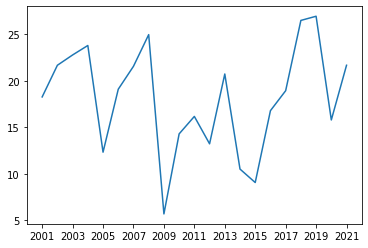

In [38]:
yearly_profit = {}
years = range(2001,2022)
for year in years:
    game_year = {}
    game_year["games"] = sum((bet_results["date"] > datetime.datetime(year=year,month=1,day=1)) & (bet_results["date"] < datetime.datetime(year=year+1,month=1,day=1)))
    game_year["profit"] = round(bet_results[(bet_results["date"] > datetime.datetime(year=year,month=1,day=1)) & (bet_results["date"] < datetime.datetime(year=year+1,month=1,day=1))]["decision_tree"].sum(),2)
    game_year["avg"] = round((game_year["profit"]-input_per_game*game_year["games"])/game_year["games"],2)
    yearly_profit[year] = game_year

avg = [yearly_profit[key]["avg"] for key in yearly_profit]
plt.xticks(np.arange(min(years), max(years)+1, 2.0))
plt.plot(years,avg)

# 7. Model Usage

In [39]:
def Predict(player_1_name:str,player_2_name:str,player_1_seed:int = None,player_2_seed:int=None,date:datetime=datetime.datetime.now(),model:str=DECISION_TREE):
    """
    Takes 2 Player Names and Prints the Prediction of the Winner.
    
    Optional Parameters:
    - player_1_seed: Seed of Player 1
    - player_2_seed: Seed of Player 2
    - date: Date of the Game
    - model: Model to use
    """
    #prepare all the information
    date = date.date()
    p1 = player_metadata_lookup[player_1_name]
    p2 = player_metadata_lookup[player_2_name]
    
    p1_rank = player_rank_lookup.getRank(str(p1["id"]),date)
    p2_rank = player_rank_lookup.getRank(str(p2["id"]),date)
    
    p1_age = (date - p1["dob"]).days // 365
    p1_height = p1["height"]
        
    p2_age = (date - p2["dob"]).days // 365
    p2_height = p2["height"]
    
    
    knowledgegap = knowledge_gap(len(player_match_history_lookup.getAllMatches(player_1_name,date)),len(player_match_history_lookup.getAllMatches(player_2_name,date)))
    
    historical_matches = player_match_history_lookup.getMatchHistory(player_1_name,player_2_name)
    
    if len(historical_matches) == 0:
        historicalgap = 0.5 # no information  
    else:
        p1_wins = len([match for match in historical_matches if match["won"]])
        p2_wins = len([match for match in historical_matches if not match["won"]])
        historicalgap = historical_gap(p1_wins,p2_wins)
    
    if player_1_seed == None and player_2_seed == None:
        seedgap = 0.5
    elif player_1_seed == None and player_2_seed != None:
        seedgap = 1.0
    elif player_1_seed != None and player_2_seed == None:
        seedgap = 0.0  
    else:
        seedgap = seed_gap(player_1_seed,player_2_seed)
             
    skillgap = skill_gap(p1_rank,p2_rank)  
    heightgap = height_gap(p1_height,p2_height)
    agegap = age_gap(p1_age,p2_age)   
    
    features = [seedgap,skillgap,agegap,heightgap,knowledgegap,historicalgap]
    features = np.array(features)
    features = pipeline.transform(features.reshape(1,-1))
    winner = models[model].predict(features)[0]
    print(f"{player_1_name} vs {player_2_name}:")
    if winner == 1:
        print(f"{player_2_name} is the predicted winner!")
    else:
        print(f"{player_1_name} is the predicted winner!")
    
Predict("Alexander Zverev","Rafael Nadal")
Predict("NOVAK DJOKOVIC","Rafael Nadal")

Alexander Zverev vs Rafael Nadal:
Rafael Nadal is the predicted winner!
NOVAK DJOKOVIC vs Rafael Nadal:
NOVAK DJOKOVIC is the predicted winner!


C:\Users\andyz\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\andyz\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
